In [11]:
%load_ext autoreload

%autoreload 2
import sys
import corner
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import scipy
from astropy.coordinates import SkyCoord
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
from astropy.table import Table
import abundance as cl_count
import pickle

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

import pyccl as ccl
import edit
import h5py, glob
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)


where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
def concatenate(n_cat):
    ra, dec, redshift, Mvir = [], [], [], []
    for i in range(n_cat):
        cat_i = pd.read_csv(cat[i+22] ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
        ra_, dec_, redshift_, Mvir_ = cat_i['ra'], cat_i['dec'], cat_i['z'], cat_i['M']/0.6777
        ra.extend(ra_)
        dec.extend(dec_)
        redshift.extend(redshift_)
        Mvir.extend(Mvir_)
    return np.array(ra), np.array(dec), np.array(redshift), np.array(Mvir)

In [80]:
def mask_fsky(fsky, cat_test, reshape=True):
    if reshape==True:
        theta_aperture = np.arccos(1-2*fsky)*180/np.pi #deg
        ra_center, dec_center = 180, 60
        cat_center_SkyCoord =SkyCoord(ra=np.array([ra_center])*u.degree, dec=np.array([dec_center])*u.degree)
        pos_ra, pos_dec = cat_test['ra'], cat_test['dec']
        cat_pinocchio_SkyCoord=SkyCoord(ra=np.array(pos_ra)*u.degree, dec=np.array(pos_dec)*u.degree)
        idxcat_center, idxcat_pinocchio, d2d, d3d = cat_center_SkyCoord.search_around_sky(cat_pinocchio_SkyCoord, theta_aperture*u.deg)
        cat_test = cat_test[idxcat_center]
    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']
    return ra, dec, redshift, Mvir

In [81]:
#SPT
n_cat = 1
ra, dec, redshift, Mvir = concatenate(n_cat)
cat_SPT = Table()
cat_SPT['ra'] = ra
cat_SPT['dec'] = dec
cat_SPT['z'] = redshift
cat_SPT['M'] = Mvir
mass_in = ccl.halos.massdef.MassDef('vir', 'matter')
mass_out = ccl.halos.massdef.MassDef('500', 'critical')
concentration = conc = ccl.halos.concentration.ConcentrationDuffy08(mass_def=mass_in)
mass_ranslator = ccl.halos.massdef.mass_translator(mass_in=mass_in,
                                                   mass_out=mass_out, 
                                                   concentration=concentration)
Omega_SPT = 2500
Omega_full = 360**2/np.pi
ra_SPT, dec_SPT, redshift_SPT, Mvir_SPT = mask_fsky(Omega_SPT/Omega_full, cat_SPT)
mask_SPT_z = redshift_SPT > 0.25
M500c_SPT = np.array([mass_ranslator(cosmo, Mvir_SPT[i], 1/(1+redshift_SPT[i])) for i in range(len(Mvir_SPT))])
mask_SPT_m = M500c_SPT  > 3*1e14
mask_SPT = mask_SPT_m*mask_SPT_z

In [82]:
np.sum(mask_SPT)

1133

In [83]:
#eROSITA
n_cat = 4
ra, dec, redshift, Mvir = concatenate(n_cat)
cat_eROSITA = Table()
cat_eROSITA['ra'] = ra
cat_eROSITA['dec'] = dec
cat_eROSITA['z'] = redshift
cat_eROSITA['M'] = Mvir
mass_in = ccl.halos.massdef.MassDef('vir', 'matter')
mass_out = ccl.halos.massdef.MassDef('500', 'critical')
concentration = conc = ccl.halos.concentration.ConcentrationDuffy08(mass_def=mass_in)
mass_ranslator = ccl.halos.massdef.mass_translator(mass_in=mass_in,
                                                   mass_out=mass_out, 
                                                   concentration=concentration)
Omega_eROSITA = 42100
ra_eROSITA, dec_eROSITA, redshift_eROSITA, Mvir_eROSITA = mask_fsky(Omega_eROSITA/42100, cat_eROSITA, reshape=False)
mask_eROSITA_z = redshift_eROSITA > 0.0
M500c_eROSITA = np.array([mass_ranslator(cosmo, Mvir_eROSITA[i], 1/(1+redshift_eROSITA[i])) for i in range(len(Mvir_eROSITA))])
mask_eROSITA_m = (M500c_eROSITA  > 2.3 * redshift_eROSITA * 1e14) * (M500c_eROSITA > 7*1e13) * (Mvir_eROSITA > 1e14)
mask_eROSITA = mask_eROSITA_m*mask_eROSITA_z

In [84]:
#Planck
n_cat = 2
ra, dec, redshift, Mvir = concatenate(n_cat)
cat_Planck = Table()
cat_Planck['ra'] = ra
cat_Planck['dec'] = dec
cat_Planck['z'] = redshift
cat_Planck['M'] = Mvir
mass_in = ccl.halos.massdef.MassDef('vir', 'matter')
mass_out = ccl.halos.massdef.MassDef('500', 'critical')
concentration = conc = ccl.halos.concentration.ConcentrationDuffy08(mass_def=mass_in)
mass_ranslator = ccl.halos.massdef.mass_translator(mass_in=mass_in,
                                                   mass_out=mass_out, 
                                                   concentration=concentration)
Omega_Planck = 42100
ra_Planck, dec_Planck, redshift_Planck, Mvir_Planck = mask_fsky(Omega_Planck/42100, cat_Planck, reshape=False)
mask_Planck_z = redshift_Planck > 0.0
M500c_Planck = np.array([mass_ranslator(cosmo, Mvir_Planck[i], 1/(1+redshift_Planck[i])) for i in range(len(Mvir_Planck))])
mask_Planck_m = (M500c_Planck >  1e14*(1 + 14 * redshift_Planck ** .75)) * (Mvir_Planck > 1e14) * (redshift_Planck < 0.8)
mask_Planck = mask_Planck_m*mask_Planck_z

In [85]:
#ACT
n_cat = 7
ra, dec, redshift, Mvir = concatenate(n_cat)
cat_ACT = Table()
cat_ACT['ra'] = ra
cat_ACT['dec'] = dec
cat_ACT['z'] = redshift
cat_ACT['M'] = Mvir
mass_in = ccl.halos.massdef.MassDef('vir', 'matter')
mass_out = ccl.halos.massdef.MassDef('500', 'critical')
concentration = conc = ccl.halos.concentration.ConcentrationDuffy08(mass_def=mass_in)
mass_ranslator = ccl.halos.massdef.mass_translator(mass_in=mass_in,
                                                   mass_out=mass_out, 
                                                   concentration=concentration)
Omega_ACT = (13211/7)
ra_ACT, dec_ACT, redshift_ACT, Mvir_ACT = mask_fsky(Omega_ACT/42100, cat_ACT, reshape=True)
mask_ACT_z = redshift_ACT > 0.1

In [86]:
M500c_ACT = np.array([mass_ranslator(cosmo, Mvir_ACT[i], 1/(1+redshift_ACT[i])) for i in range(len(Mvir_ACT))])

In [87]:
np.log10(3.5e14)

14.544068044350276

In [88]:
mask_ACT_m = (M500c_ACT >  3.5e14)
mask_ACT = mask_ACT_m * mask_ACT_z

677


Text(0.5, 0, 'redshift')

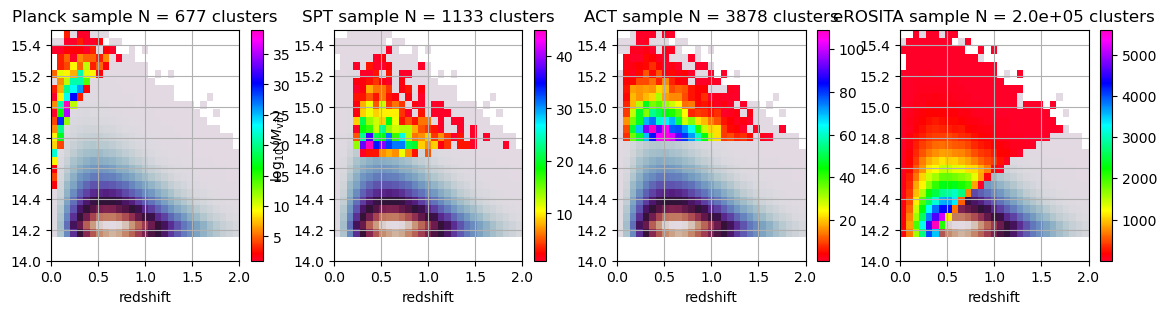

In [89]:
plt.figure(figsize=(14,3))
bins = [np.linspace(0, 2, 30), np.linspace(14, 15.5, 30)]
plt.subplot(141)

plt.title(f'Planck sample N = {np.sum(mask_Planck):.0f} clusters')
plt.hist2d(redshift, np.log10(Mvir),alpha=1, bins=bins,cmap='twilight', cmin=1)
print(np.sum(mask_Planck))
plt.hist2d(redshift_Planck[mask_Planck], np.log10(Mvir_Planck[mask_Planck]),alpha=1, cmap = 'gist_rainbow',bins=bins, cmin=1 )
plt.colorbar()
plt.grid()
plt.xlim(0, 2)
plt.ylim(14., 15.5)
plt.xlabel('redshift')

plt.subplot(142)

plt.title(f'SPT sample N = {np.sum(mask_SPT):.0f} clusters')
plt.hist2d(redshift, np.log10(Mvir),alpha=1,bins=bins, cmap='twilight', cmin=1)
plt.hist2d(redshift_SPT[mask_SPT], np.log10(Mvir_SPT[mask_SPT]), cmap = 'gist_rainbow', bins=bins, cmin=1)
plt.colorbar()
plt.grid()
plt.xlim(0, 2)
plt.ylim(14., 15.5)
plt.xlabel('redshift')
plt.ylabel(r'$\log_{10}(M_{\rm vir})$')
plt.subplot(143)
plt.title(f'ACT sample N = {np.sum(mask_ACT):.0f} clusters')
plt.hist2d(redshift, np.log10(Mvir),alpha=1, bins=bins,cmap='twilight', cmin=1)
plt.hist2d(redshift_ACT[mask_ACT], np.log10(Mvir_ACT[mask_ACT]), cmap = 'gist_rainbow',bins=bins, cmin=1)#1, s=.8, alpha=.2, color = 'b', marker='+')
plt.colorbar()
plt.grid()
plt.xlim(0, 2)
plt.ylim(14., 15.5)
plt.xlabel('redshift')
plt.subplot(144)

plt.title(f'eROSITA sample N = {np.sum(mask_eROSITA):.1e} clusters')
plt.hist2d(redshift, np.log10(Mvir),alpha=1, bins=bins,cmap='twilight', cmin=1)
plt.hist2d(redshift_eROSITA[mask_eROSITA], np.log10(Mvir_eROSITA[mask_eROSITA]), cmap = 'gist_rainbow',bins=bins, cmin=1)#1, s=.8, alpha=.2, color = 'b', marker='+')
plt.colorbar()
plt.grid()
plt.xlim(0, 2)
plt.ylim(14., 15.5)
plt.xlabel('redshift')

In [90]:
np.sum(mask_eROSITA)

198176